In [4]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging
from csrank.experiments import *
import numpy as np

In [5]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results.log')
setup_logging(log_path=log_path)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc", "exp_dc"]

In [6]:
def create_jobs_csv():
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    start = 3
    schema = 'discrete_choice'
    select_jobs = "SELECT * from {}.{}".format('{}', "avail_jobs")
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    self.init_connection()
    #print(select_st)
    
    self.cursor_db.execute("select * from discrete_choice.avail_jobs where job_id=1")
    columns = dict(self.cursor_db.fetchone()).keys()
    print(columns)
    self.init_connection()
    self.cursor_db.execute(select_jobs.format('discrete_choice'))
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        one_row = [job[key] for key in columns]
        data.append(one_row)
    self.init_connection()
    self.cursor_db.execute(select_jobs.format('pymc3_discrete_choice'))
    for job in self.cursor_db.fetchall():
        job = dict(job)
        one_row = [job[key] for key in columns]
        data.append(one_row)
    self.close_connection()
    df = pd.DataFrame(data, columns=columns)
    df_path = os.path.join(DIR_PATH, 'jobs' , "job_configs.csv")
    df.to_csv(df_path)
create_jobs_csv()

dict_keys(['job_id', 'fold_id', 'dataset', 'learner', 'experiment_schema', 'experiment_table', 'dataset_params', 'fit_params', 'learner_params', 'hp_ranges', 'hp_fit_params', 'hp_iters', 'is_gpu', 'seed', 'inner_folds', 'duration', 'learning_problem', 'validation_loss', 'hash_value', 'job_allocated_time'])


In [7]:
def get_letor_string(dp):
    y =  str(dp.get('year', "EXPEDIA"))
    
    n = str(dp.get("n_objects", 5))
    return "y_{}_n_{}".format(y,n)
def get_results_for_dataset(DATASET, del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'discrete_choice'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {3} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset=\'{2}\'"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if job['dataset'] in ["letor_dc", "exp_dc"]:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3_discrete_choice")
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if job['dataset'] in ["letor_dc", "exp_dc"]:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    columns = list(df_full.columns)
    return df_full, columns

In [25]:
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini
def get_name(name):
    named = dict()
    named["NEAREST_NEIGHBOUR_MEDOID"] = "Nearest Neighbour"
    named["NEAREST_NEIGHBOUR"] = "Most Similar Movie"
    named["DISSIMILAR_NEAREST_NEIGHBOUR"] = "Most Dissimilar Movie"
    named["CRITIQUE_FIT_LESS"] = "Best Critique-Fit Movie d=-1"
    named["CRITIQUE_FIT_MORE"] = "Best Critique-Fit Movie d=+1"
    named["DISSIMILAR_CRITIQUE_LESS"] = "Impostor Critique-Fit Movie d=-1"
    named["DISSIMILAR_CRITIQUE_MORE"] = "Impostor Critique-Fit Movie d=+1"
    named["UNIQUE_MAX_OCCURRING"] = "Mode"
    named["HYPERVOLUME"] = "Pareto"
    named["SUSHI_DC"] = "SUSHI"
    named["Y_2007_N_10"] = "MQ2007 10 Objects"
    named["Y_2007_N_5"] = "MQ2007 5 Objects"
    named["Y_2008_N_10"] = "MQ2008 10 Objects"
    named["Y_2008_N_5"] = "MQ2008 5 Objects"
    if name not in named.keys():
        named[name] = name.lower().title()
    return named[name]
def create_combined_dfs(DATASET):
    df_full, cols = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            elif not np.all(np.isnan(mean)):
                data.append(one_row)
        if len(feta_r)!=0:
            data.append(feta_r)
        if len(ranknet_r)!=0:
            data.append(ranknet_r)
        if len(fate_r)!=0:
            data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df
df = create_combined_dfs(datasets[-1])
df

MULTINOMIAL_LOGIT_MODEL
[0.206 0.335 0.432 0.509 0.573 0.625]
FETA_DC_SHALLOW_ZERO
[0.062 0.117 0.173 0.228 0.283 0.333]
MIXED_LOGIT_MODEL
[0.2   0.324 0.419 0.496 0.56  0.612]
MULTINOMIAL_LOGIT_MODEL
[0.204 0.333 0.429 0.506 0.571 0.624]
NESTED_LOGIT_MODEL
[0.204 0.332 0.428 0.505 0.57  0.623]


,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricalaccuracyse,categoricaltopk2se,categoricaltopk3se,categoricaltopk4se,categoricaltopk5se
0,Y_EXPEDIA_N_10,MULTINOMIAL_LOGIT_MODEL,0.206,0.335,0.432,0.509,0.573,0.001,0.001,0.001,0.001,0.001
1,Y_EXPEDIA_N_5,MIXED_LOGIT_MODEL,0.2,0.324,0.419,0.496,0.56,0.006,0.016,0.023,0.028,0.032
2,Y_EXPEDIA_N_5,MULTINOMIAL_LOGIT_MODEL,0.204,0.333,0.429,0.506,0.571,0.001,0.002,0.002,0.002,0.001
3,Y_EXPEDIA_N_5,NESTED_LOGIT_MODEL,0.2040,0.3320,0.4280,0.5050,0.5700,NaN,NaN,NaN,NaN,NaN
4,Y_EXPEDIA_N_5,FETA_DC,0.062,0.117,0.173,0.228,0.283,0.015,0.027,0.035,0.043,0.048


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plot.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        sub_plot.plot(N_OBJECTS_ARRAY, acc, label='RANDOM', linewidth=1, color='k', marker='H')
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.05))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "thesis", "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)

    i = 0
    if len(grouped)in [4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[1,2,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]], 'exp_dc': [[0,1]]}
    #inds = 
    zoom = False
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        if DATASET =='letor_dc':
            #sharex = True
            a = 2
            b = 2
            size = (15,12)
            zoom = True
        if DATASET =='sushi_dc':
            #sharex = True
            a = 1
            b = 2
            size = (15,6)
            zoom = True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc
FATE_DC         dataset  learner  categoricalaccuracy  categoricaltopk2  \
31  HYPERVOLUME  FATE_DC               0.7363            0.8625   
68  HYPERVOLUME  FATE_DC               0.7036            0.8281   
25  HYPERVOLUME  FATE_DC               0.7212            0.8437   
6   HYPERVOLUME  FATE_DC               0.7380            0.8623   
16  HYPERVOLUME  FATE_DC               0.7499            0.8775   

    categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
31            0.9240            0.9509            0.9684            0.9802  
68            0.9005            0.9362            0.9592            0.9752  
25            0.9143            0.9454            0.9658            0.9790  
6             0.9248            0.9535            0.9721            0.9828  
16            0.9352            0.9589            0.9744            0.9838  
[0.73  0.855 0.92  0.949 0.968 0.98 ]
FETA_DC         dataset  learner  categoricalaccuracy  categoricaltopk2  \
3

[0.02  0.082 0.191 0.336 0.5   0.663]
NESTED_LOGIT_MODEL     dataset             learner  categoricalaccuracy  categoricaltopk2  \
78   MEDOID  NESTED_LOGIT_MODEL               0.0517            0.1514   
100  MEDOID  NESTED_LOGIT_MODEL               0.0636            0.1329   
101  MEDOID  NESTED_LOGIT_MODEL               0.0607            0.1314   
103  MEDOID  NESTED_LOGIT_MODEL               0.0331            0.1056   
104  MEDOID  NESTED_LOGIT_MODEL               0.0340            0.1076   

     categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
78             0.2256            0.3196            0.4315            0.5745  
100            0.2200            0.3250            0.4517            0.5950  
101            0.2136            0.3196            0.4471            0.5891  
103            0.2095            0.3412            0.4898            0.6413  
104            0.2134            0.3467            0.4924            0.6411  
[0.049 0.126 0.216 0.33  0.462

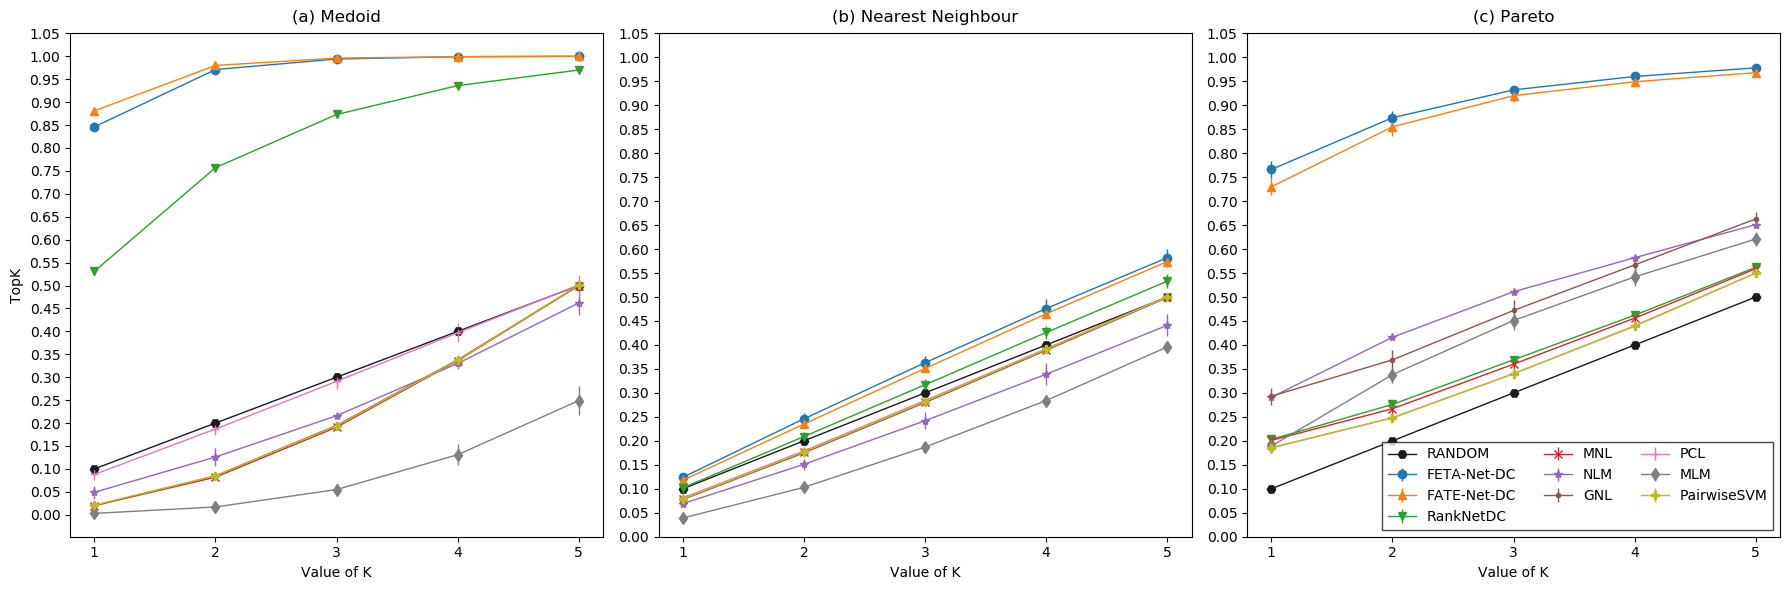

mnist_dc
FATE_DC     dataset  learner  categoricalaccuracy  categoricaltopk2  categoricaltopk3  \
33  LARGEST  FATE_DC               0.9798            0.9945            0.9975   
35  LARGEST  FATE_DC               0.9798            0.9936            0.9966   
28  LARGEST  FATE_DC               0.9792            0.9951            0.9978   
6   LARGEST  FATE_DC               0.9709            0.9931            0.9974   
7   LARGEST  FATE_DC               0.9747            0.9917            0.9958   

    categoricaltopk4  categoricaltopk5  categoricaltopk6  
33            0.9986            0.9993            0.9997  
35            0.9980            0.9988            0.9994  
28            0.9988            0.9993            0.9997  
6             0.9988            0.9994            0.9996  
7             0.9976            0.9987            0.9993  
[0.977 0.994 0.997 0.998 0.999 1.   ]
FETA_DC     dataset  learner  categoricalaccuracy  categoricaltopk2  categoricaltopk3  \
37  LARGEST  FE

MULTINOMIAL_LOGIT_MODEL     dataset                  learner  categoricalaccuracy  categoricaltopk2  \
105  MEDIAN  MULTINOMIAL_LOGIT_MODEL               0.3930            0.6253   
120  MEDIAN  MULTINOMIAL_LOGIT_MODEL               0.3971            0.6245   
119  MEDIAN  MULTINOMIAL_LOGIT_MODEL               0.3958            0.6206   
118  MEDIAN  MULTINOMIAL_LOGIT_MODEL               0.3952            0.6189   
137  MEDIAN  MULTINOMIAL_LOGIT_MODEL               0.3917            0.6178   

     categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
105            0.7770            0.8572            0.8931            0.9162  
120            0.7890            0.8759            0.9140            0.9363  
119            0.7832            0.8701            0.9108            0.9352  
118            0.7811            0.8622            0.8972            0.9181  
137            0.7771            0.8608            0.9001            0.9245  
[0.395 0.621 0.781 0.865 0.903 0.

[0.284 0.548 0.783 0.904 0.954 0.977]
FETA_DC_ZERO                  dataset       learner  categoricalaccuracy  categoricaltopk2  \
87  UNIQUE_MAX_OCCURRING  FETA_DC_ZERO               0.2501            0.4650   
86  UNIQUE_MAX_OCCURRING  FETA_DC_ZERO               0.2437            0.4760   
72  UNIQUE_MAX_OCCURRING  FETA_DC_ZERO               0.2437            0.4680   
73  UNIQUE_MAX_OCCURRING  FETA_DC_ZERO               0.2423            0.4624   
81  UNIQUE_MAX_OCCURRING  FETA_DC_ZERO               0.3078            0.5504   

    categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
87            0.6650            0.7825            0.8646            0.9172  
86            0.6708            0.8040            0.8703            0.9226  
72            0.6606            0.7919            0.8703            0.9226  
73            0.6507            0.7825            0.8646            0.9172  
81            0.7881            0.9092            0.9569            0.9786  


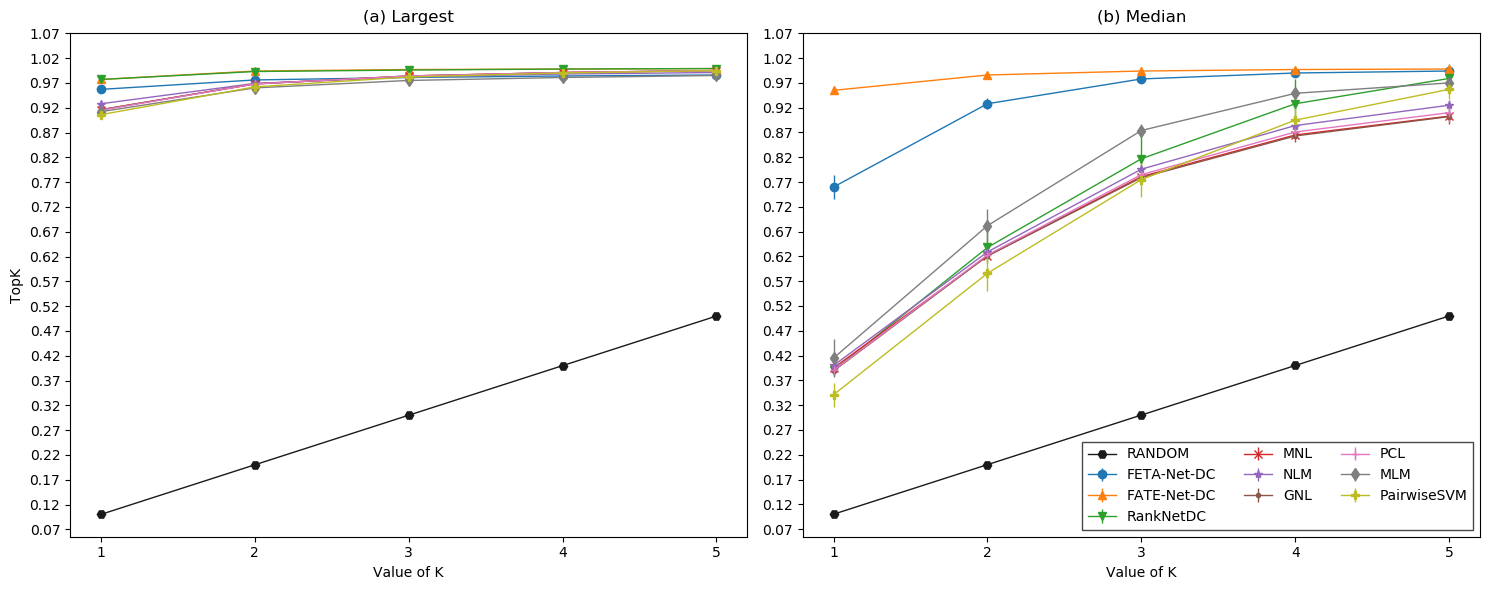

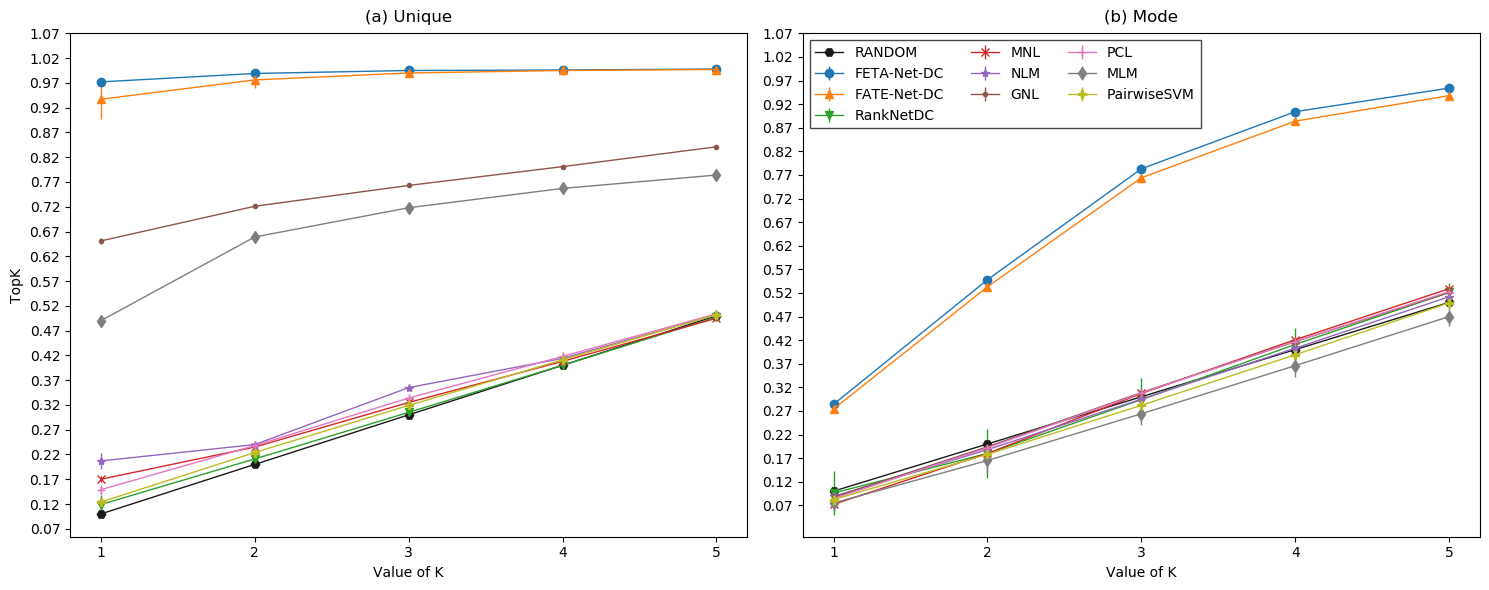

tag_genome_dc
FATE_DC               dataset  learner  categoricalaccuracy  categoricaltopk2  \
35  CRITIQUE_FIT_LESS  FATE_DC               0.2255            0.3521   
49  CRITIQUE_FIT_LESS  FATE_DC               0.2276            0.3563   
52  CRITIQUE_FIT_LESS  FATE_DC               0.2229            0.3488   
47  CRITIQUE_FIT_LESS  FATE_DC               0.2246            0.3517   
14  CRITIQUE_FIT_LESS  FATE_DC               0.2285            0.3547   

    categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
35            0.4603            0.5583            0.6504            0.7333  
49            0.4675            0.5662            0.6567            0.7400  
52            0.4589            0.5575            0.6488            0.7305  
47            0.4586            0.5564            0.6480            0.7332  
14            0.4659            0.5641            0.6542            0.7345  
[0.226 0.353 0.462 0.56  0.652 0.734]
FETA_DC                dataset  learner

GENERALIZED_EXTREME_VALUE                dataset                    learner  categoricalaccuracy  \
251  CRITIQUE_FIT_MORE  GENERALIZED_EXTREME_VALUE               0.1614   
248  CRITIQUE_FIT_MORE  GENERALIZED_EXTREME_VALUE               0.1742   
246  CRITIQUE_FIT_MORE  GENERALIZED_EXTREME_VALUE               0.1718   
249  CRITIQUE_FIT_MORE  GENERALIZED_EXTREME_VALUE               0.1698   
252  CRITIQUE_FIT_MORE  GENERALIZED_EXTREME_VALUE               0.1692   

     categoricaltopk2  categoricaltopk3  categoricaltopk4  categoricaltopk5  \
251            0.2805            0.3875            0.4894            0.5900   
248            0.2957            0.4003            0.4976            0.5940   
246            0.2887            0.3919            0.4946            0.5959   
249            0.2861            0.3963            0.4964            0.5929   
252            0.2840            0.3879            0.4875            0.5863   

     categoricaltopk6  
251            0.6908  
248   

FETA_DC                       dataset  learner  categoricalaccuracy  categoricaltopk2  \
133  DISSIMILAR_CRITIQUE_MORE  FETA_DC               0.9095            0.9682   
135  DISSIMILAR_CRITIQUE_MORE  FETA_DC               0.9054            0.9665   
139  DISSIMILAR_CRITIQUE_MORE  FETA_DC               0.9059            0.9686   
141  DISSIMILAR_CRITIQUE_MORE  FETA_DC               0.9071            0.9654   
145  DISSIMILAR_CRITIQUE_MORE  FETA_DC               0.9065            0.9673   

     categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
133            0.9818            0.9887            0.9930            0.9955  
135            0.9813            0.9886            0.9926            0.9954  
139            0.9828            0.9889            0.9932            0.9960  
141            0.9805            0.9877            0.9923            0.9949  
145            0.9820            0.9889            0.9929            0.9955  
[0.907 0.967 0.982 0.989 0.993 0.995]

RANKSVM_DC                          dataset     learner  categoricalaccuracy  \
46  DISSIMILAR_NEAREST_NEIGHBOUR  RANKSVM_DC               0.3452   
42  DISSIMILAR_NEAREST_NEIGHBOUR  RANKSVM_DC               0.3754   
44  DISSIMILAR_NEAREST_NEIGHBOUR  RANKSVM_DC               0.3652   
45  DISSIMILAR_NEAREST_NEIGHBOUR  RANKSVM_DC               0.3880   
43  DISSIMILAR_NEAREST_NEIGHBOUR  RANKSVM_DC               0.3736   

    categoricaltopk2  categoricaltopk3  categoricaltopk4  categoricaltopk5  \
46            0.5542            0.6949            0.7940            0.8636   
42            0.5877            0.7253            0.8169            0.8802   
44            0.5703            0.7071            0.8013            0.8674   
45            0.5857            0.7118            0.8003            0.8645   
43            0.5855            0.7208            0.8134            0.8787   

    categoricaltopk6  
46            0.9134  
42            0.9239  
44            0.9155  
45           

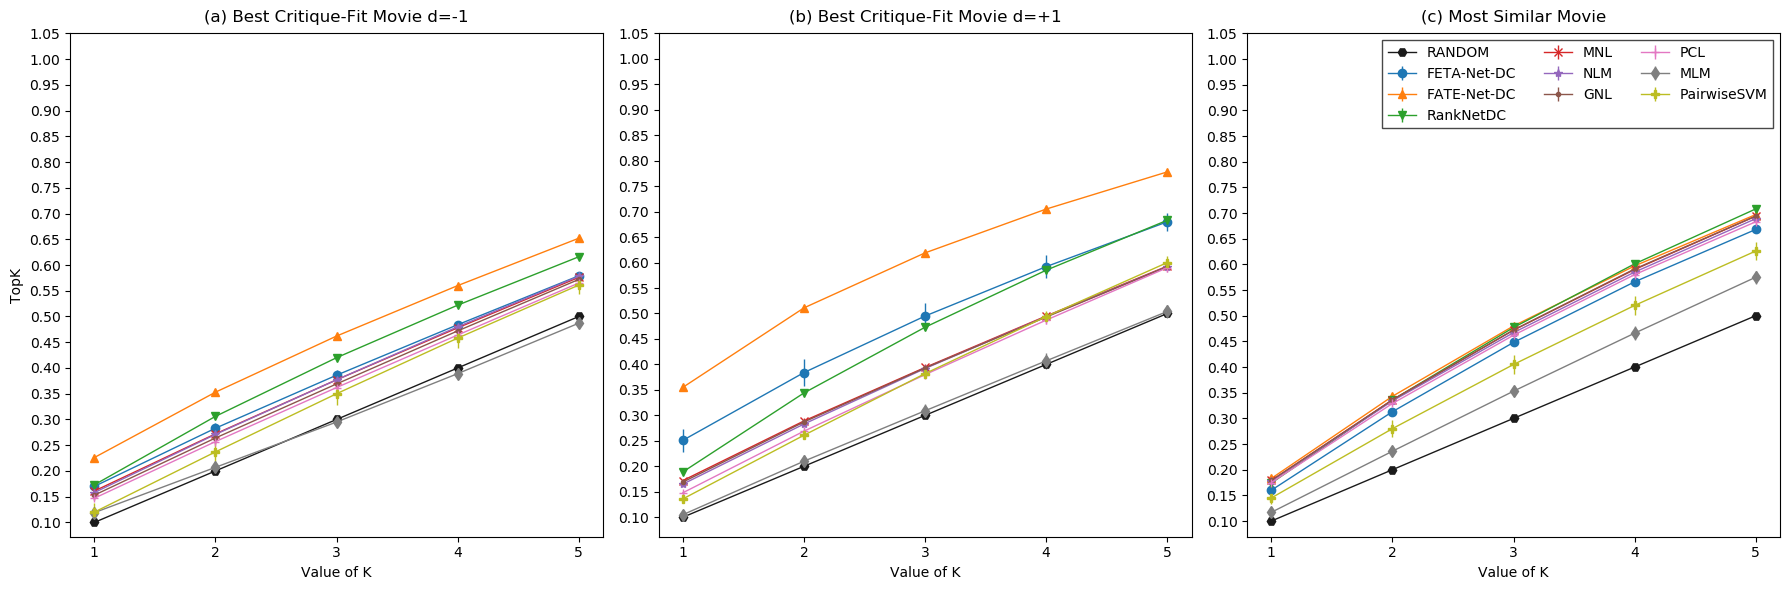

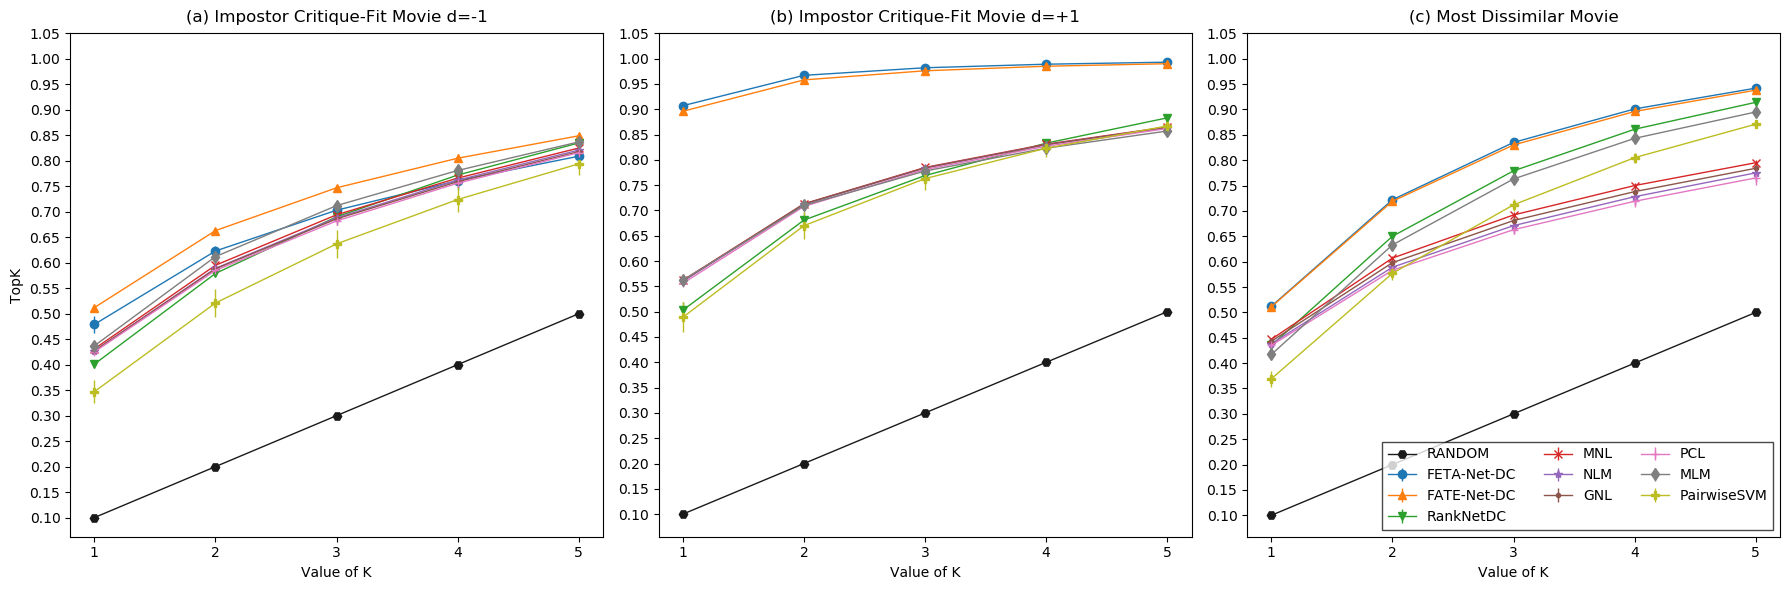

letor_dc
FATE_DC_SHALLOW         dataset          learner  categoricalaccuracy  categoricaltopk2  \
59  Y_2007_N_10  FATE_DC_SHALLOW               0.2266            0.3728   
60  Y_2007_N_10  FATE_DC_SHALLOW               0.2535            0.3850   
30  Y_2007_N_10  FATE_DC_SHALLOW               0.2478            0.3808   
10  Y_2007_N_10  FATE_DC_SHALLOW               0.2602            0.3953   
9   Y_2007_N_10  FATE_DC_SHALLOW               0.2614            0.3928   

    categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
59            0.4769            0.5810            0.6606            0.7425  
60            0.5045            0.6050            0.6925            0.7654  
30            0.4927            0.5978            0.6920            0.7683  
10            0.5172            0.6199            0.7077            0.7797  
9             0.5086            0.6072            0.6954            0.7711  
[0.25  0.385 0.5   0.602 0.69  0.765]
FETA_DC_SHALLOW_ZERO    

[0.428 0.65  0.801 0.914 1.    1.   ]
MULTINOMIAL_LOGIT_MODEL         dataset                  learner  categoricalaccuracy  \
81   Y_2007_N_5  MULTINOMIAL_LOGIT_MODEL               0.4422   
78   Y_2007_N_5  MULTINOMIAL_LOGIT_MODEL               0.4059   
77   Y_2007_N_5  MULTINOMIAL_LOGIT_MODEL               0.4166   
88   Y_2007_N_5  MULTINOMIAL_LOGIT_MODEL               0.3996   
132  Y_2007_N_5  MULTINOMIAL_LOGIT_MODEL               0.4353   

     categoricaltopk2  categoricaltopk3  categoricaltopk4  categoricaltopk5  \
81             0.6590            0.8043            0.9166               1.0   
78             0.6255            0.7887            0.9076               1.0   
77             0.6508            0.8043            0.9176               1.0   
88             0.6439            0.8007            0.9140               1.0   
132            0.6493            0.8064            0.9117               1.0   

     categoricaltopk6  
81                1.0  
78                1.0  


[0.568 0.788 0.904 0.967 1.    1.   ]
NESTED_LOGIT_MODEL         dataset             learner  categoricalaccuracy  categoricaltopk2  \
79   Y_2008_N_5  NESTED_LOGIT_MODEL               0.5649            0.7903   
135  Y_2008_N_5  NESTED_LOGIT_MODEL               0.5934            0.7987   
141  Y_2008_N_5  NESTED_LOGIT_MODEL               0.5818            0.8019   
143  Y_2008_N_5  NESTED_LOGIT_MODEL               0.5846            0.8200   
133  Y_2008_N_5  NESTED_LOGIT_MODEL               0.5077            0.7406   

     categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
79             0.9069            0.9633               1.0               1.0  
135            0.9039            0.9697               1.0               1.0  
141            0.9308            0.9780               1.0               1.0  
143            0.9354            0.9769               1.0               1.0  
133            0.8759            0.9554               1.0               1.0  
[0.566

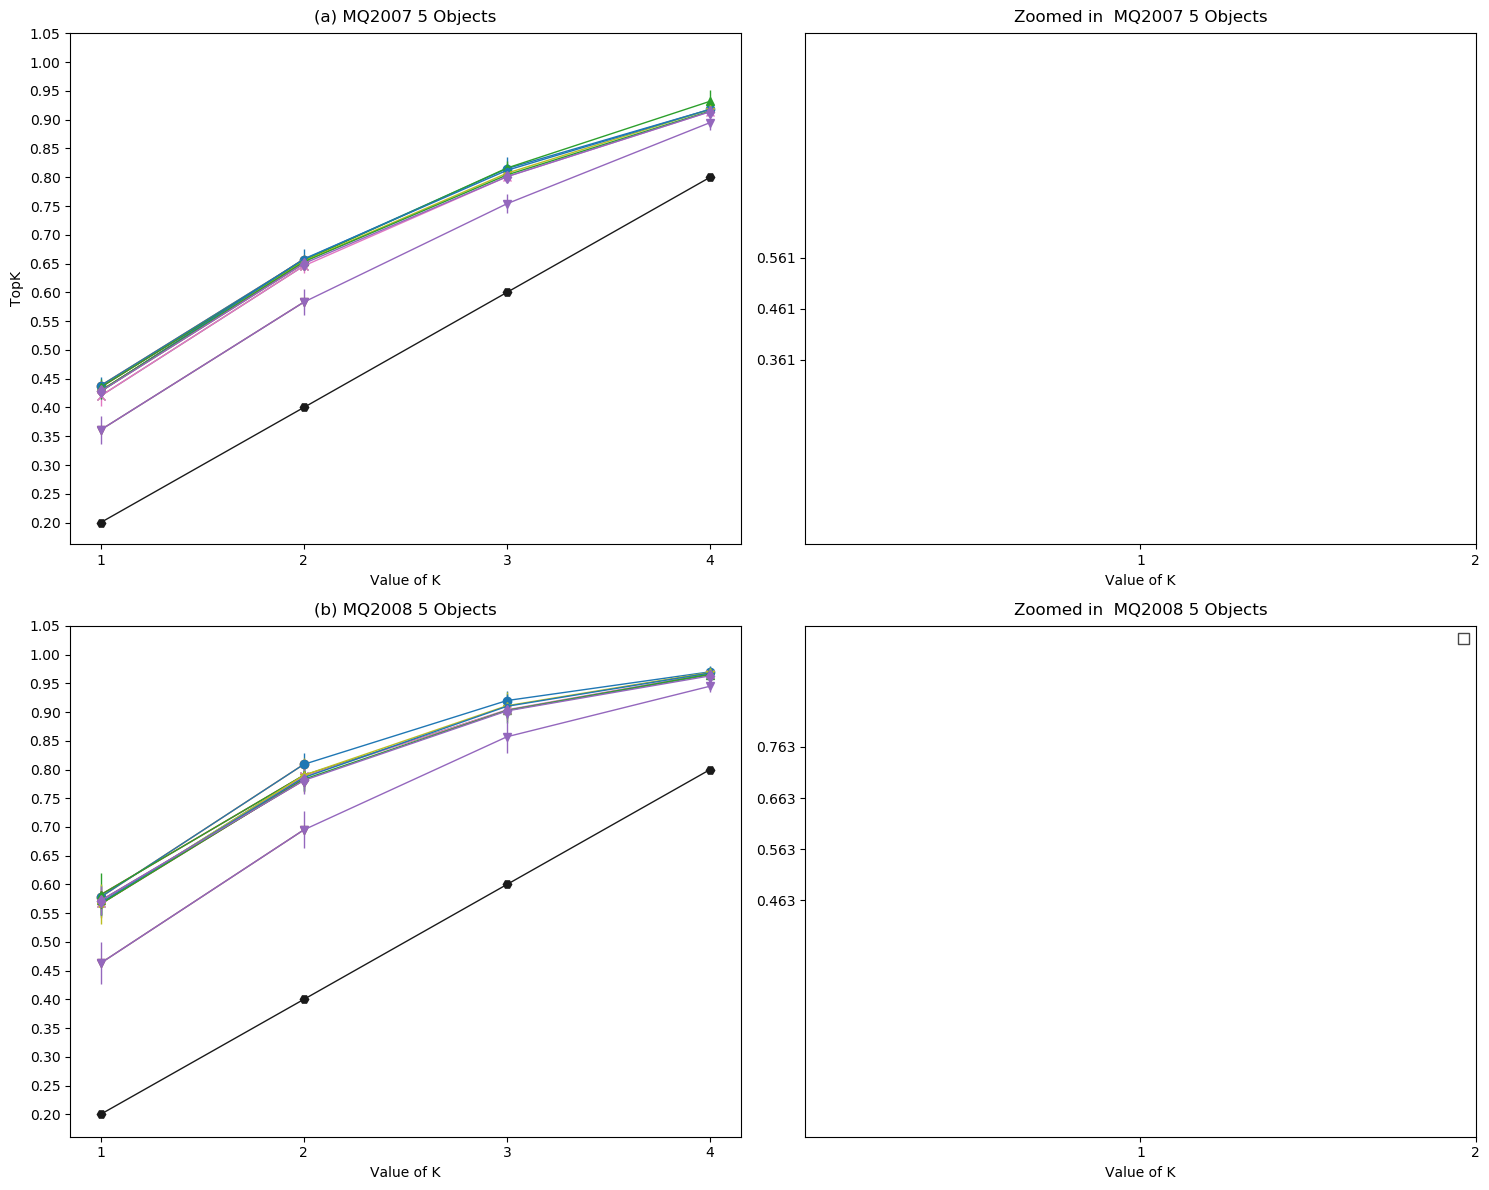

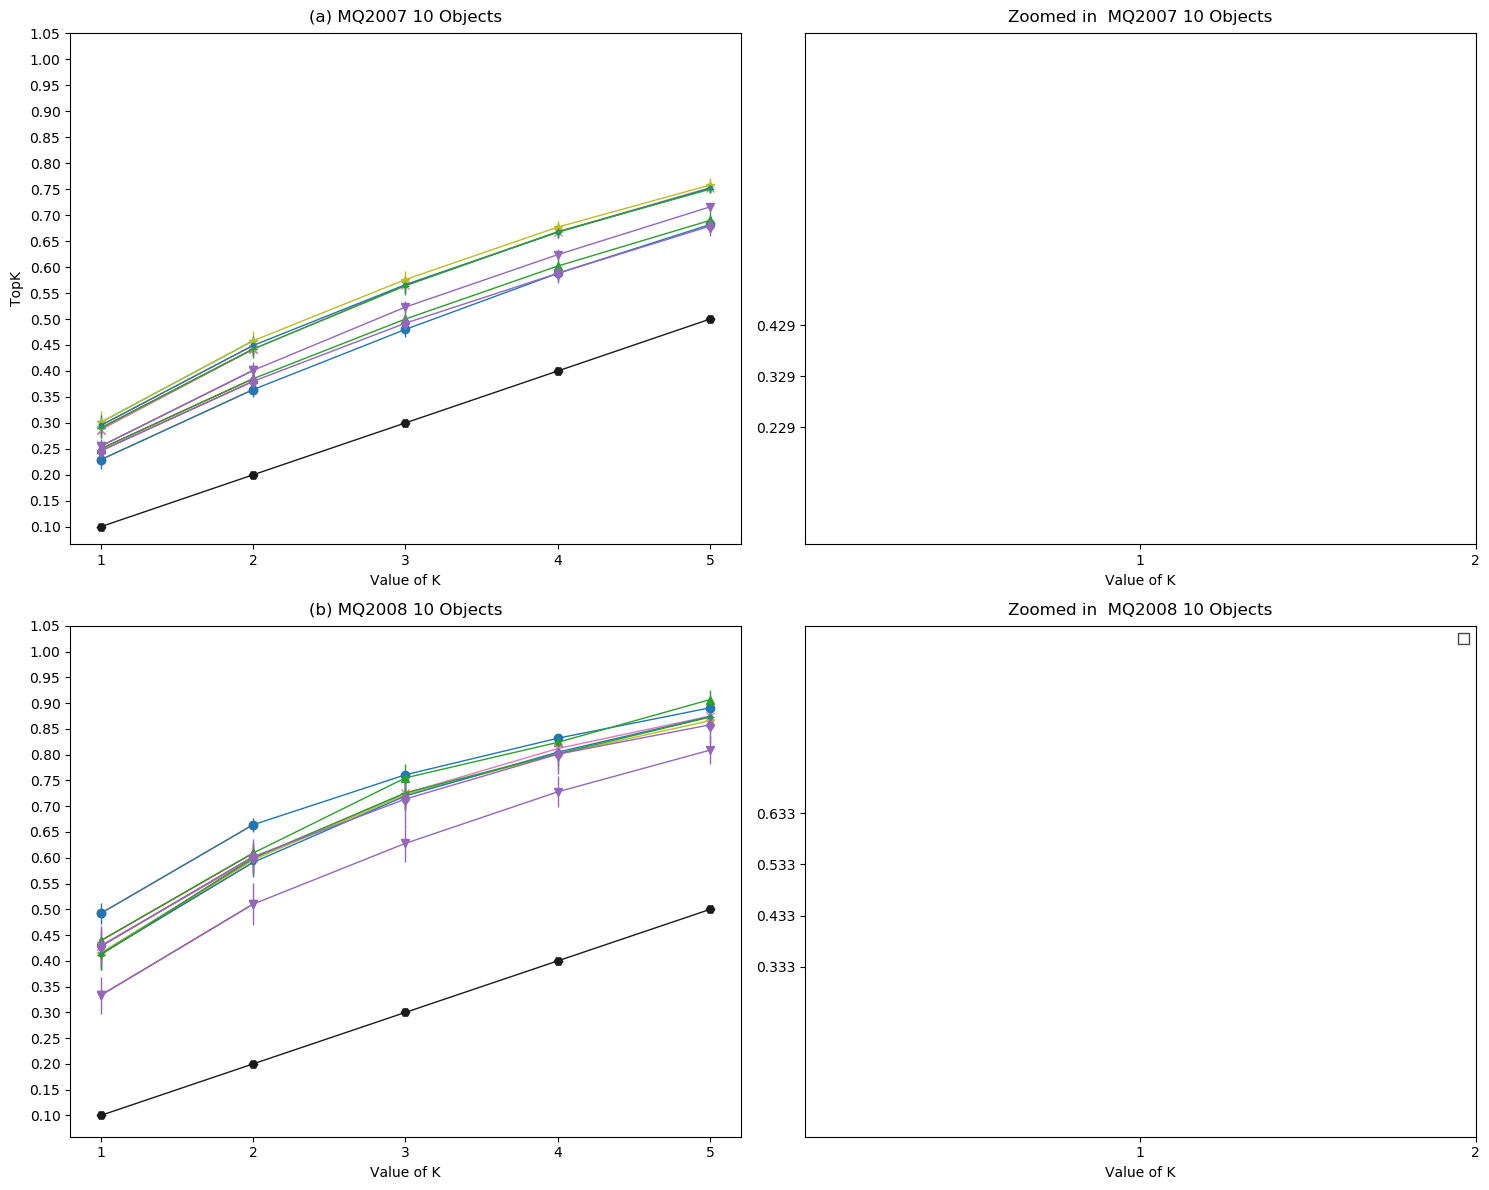

sushi_dc
FATE_DC      dataset  learner  categoricalaccuracy  categoricaltopk2  \
0   SUSHI_DC  FATE_DC               0.3070            0.4435   
22  SUSHI_DC  FATE_DC               0.2755            0.4100   
1   SUSHI_DC  FATE_DC               0.2910            0.4225   
8   SUSHI_DC  FATE_DC               0.2545            0.4100   
12  SUSHI_DC  FATE_DC               0.2910            0.4225   

    categoricaltopk3  categoricaltopk4  categoricaltopk5  categoricaltopk6  
0             0.5515            0.6770            0.7655            0.8300  
22            0.5240            0.6135            0.6835            0.7475  
1             0.5010            0.6130            0.6820            0.7755  
8             0.5280            0.6335            0.7035            0.7705  
12            0.5110            0.6135            0.7400            0.8170  
[0.284 0.422 0.523 0.63  0.715 0.788]
FETA_DC_SHALLOW      dataset          learner  categoricalaccuracy  categoricaltopk2  \
3   SUSHI_

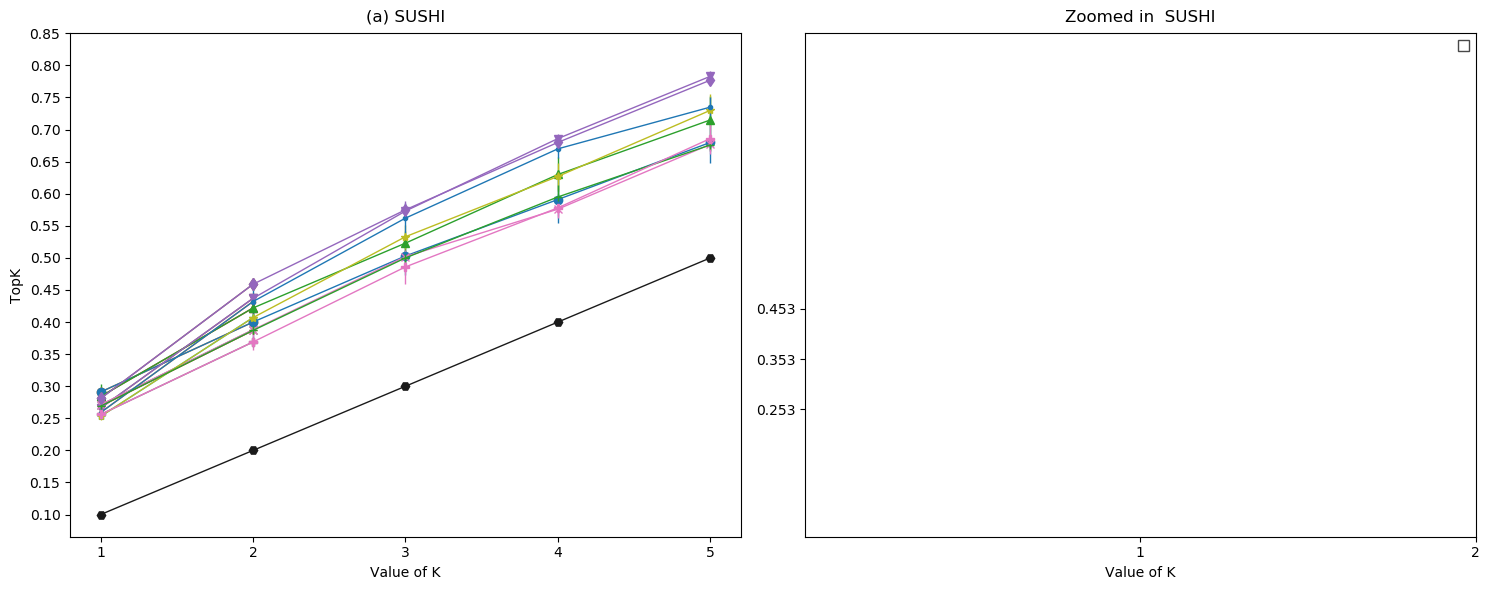

exp_dc
MULTINOMIAL_LOGIT_MODEL            dataset                  learner  categoricalaccuracy  \
16  Y_EXPEDIA_N_10  MULTINOMIAL_LOGIT_MODEL               0.2054   
13  Y_EXPEDIA_N_10  MULTINOMIAL_LOGIT_MODEL               0.2073   
12  Y_EXPEDIA_N_10  MULTINOMIAL_LOGIT_MODEL               0.2052   
11  Y_EXPEDIA_N_10  MULTINOMIAL_LOGIT_MODEL               0.2071   
9   Y_EXPEDIA_N_10  MULTINOMIAL_LOGIT_MODEL               0.2054   

    categoricaltopk2  categoricaltopk3  categoricaltopk4  categoricaltopk5  \
16            0.3343            0.4312            0.5084            0.5727   
13            0.3362            0.4332            0.5102            0.5741   
12            0.3340            0.4307            0.5075            0.5723   
11            0.3361            0.4321            0.5096            0.5736   
9             0.3337            0.4304            0.5074            0.5719   

    categoricaltopk6  
16            0.6250  
13            0.6264  
12            0.6244  

TypeError: '>=' not supported between instances of 'float' and 'NoneType'

In [19]:
from constants import DCMS
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'MNL', 'NLM', 'GNL', 'PCL', 'MLM', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
models_dict = dict(zip(Dlower, models))
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'pdf','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [20]:
def get_results_for_dataset_2(del_jid = True):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'discrete_choice'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {2} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset = ANY({3}) AND {1}.dataset_params->>\'dataset_type\'= ANY({4})"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3_discrete_choice")
    select_st = select_jobs.format(results_table, avail_jobs, metrics, "\'{synthetic_dc, mnist_dc}\'", "\'{hypervolume, unique, unique_max_occurring}\'")
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    if del_jid:
        del df_full['job_id']
    cols = list(df_full.columns)
    data = []
    dataf = []
    columns = []
    for c in cols:
        if 'categorical' in c:
            columns.append("{}se".format(c))
    columns = cols + columns
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                one_row.extend([m for m in mean])
                one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    del df['categoricaltopk6se']
    return df

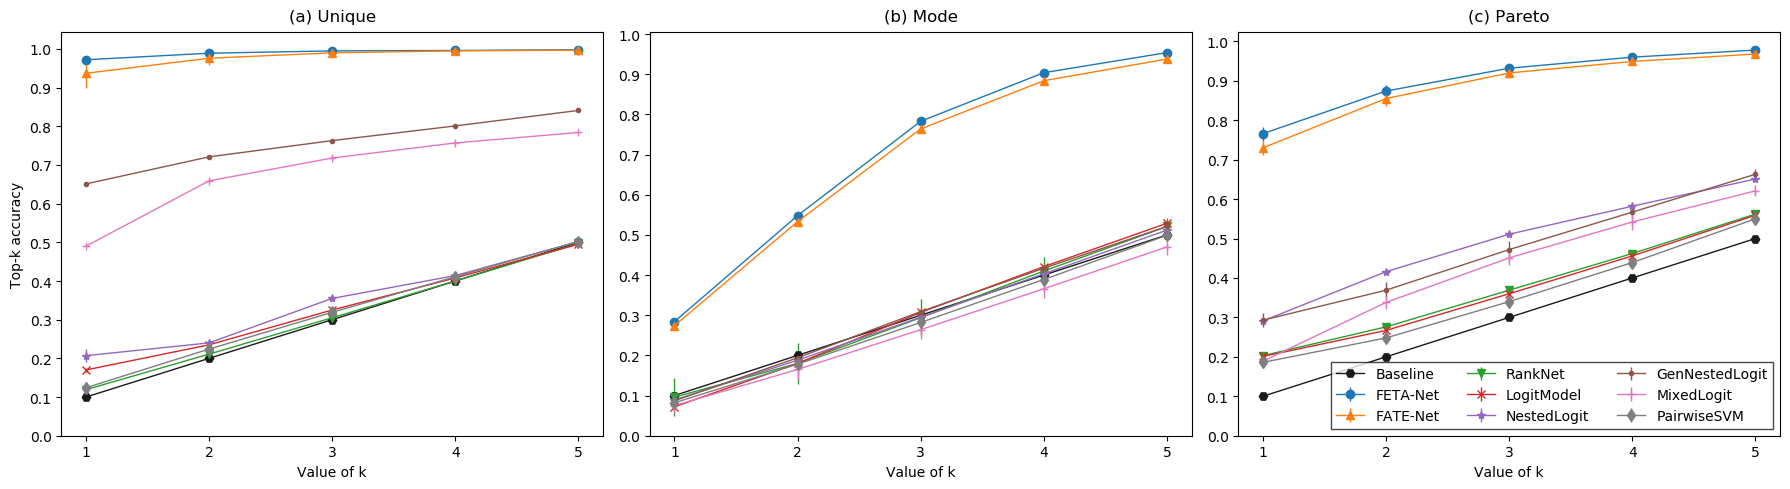

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini, sharey=False, sharex = False, zoom=False):
    fig, axs = plt.subplots(a, b, figsize=size, sharey=sharey, sharex=sharex ,frameon=True, edgecolor='k', facecolor='white')
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.subplots_adjust(hspace=0)
    markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
    n_objects = 10
    for i, group in enumerate(grouped):
        zmini = 100
        zmaxi = -100
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
            del group['categoricaltopk5se']
            n_objects = 5
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])/2) + 1
        total = len(N_OBJECTS_ARRAY)
        dataFrame = group.set_index('learner').T
        try:
            if zoom:
                sub_plot, sub_plotz = axs[i][0], axs[i][1]
            else:
                sub_plot = axs[i]
        except Exception:
            if zoom:
                sub_plot, sub_plotz = axs
            else:
                sub_plot = axs
        j = 0
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc_se = dataFrame[learner].as_matrix()[1:]
                acc = acc_se[0:total]
                se = acc_se[total:]
                zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
                sub_plot.errorbar(N_OBJECTS_ARRAY, acc, se, label=model, marker=markers[j], linewidth=1)
                if zoom:
                    sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label=model, marker=markers[j], linewidth=1)
                j = j+1
        
        acc = N_OBJECTS_ARRAY/n_objects
        sub_plot.plot(N_OBJECTS_ARRAY, acc, label='Baseline', linewidth=1, color='k', marker='H')
        #zmaxi, zmini = get_max_min(zmaxi, zmini, acc[0:2])
        if i == 0:
            sub_plot.set_ylabel(y_label)
            maxi, mini = get_max_min(maxi, mini, acc)
        sub_plot.set_yticks(np.arange(mini, maxi+0.1, 0.1))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if zoom:
            #sub_plotz.plot(N_OBJECTS_ARRAY[0:2], acc[0:2], label='RANDOM', linewidth=1, color='k', marker='H')
            sub_plotz.set_xticks(N_OBJECTS_ARRAY[0:2])
            sub_plotz.set_yticks(np.arange(zmini, zmaxi, 0.1))
            sub_plotz.set_xlabel(x_label)
            title = "{} {}".format("Zoomed in ",get_name(name))
            sub_plotz.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    fig_param['fname'] = plot_file
    plt.savefig(**fig_param)
    plt.tight_layout()
    plt.show()
from constants import DCMS
models = ['FETA-Net', 'FATE-Net', 'RankNet', 'LogitModel', 'NestedLogit', 'GenNestedLogit', 'PairedLogit', 'MixedLogit', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
models_dict = dict(zip(Dlower, models))
y_label="Top-k accuracy"
x_label="Value of k"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'pdf','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
plot_file = os.path.join(DIR_PATH, "thesis", "dc_results.pdf")
df = get_results_for_dataset_2()
df = df[df['learner']!='PAIRED_COMBINATORIAL_LOGIT']

last = int(len(df.columns[2:])/2)
maxi = 1.0 #np.around(np.max(df.as_matrix()[:,2:last+2]),2)
mini = 0.0 #np.around(np.min(df.as_matrix()[:,2:last+2]),2)
sharex = False
sharey = False
margin=0.05
grouped = df.groupby(['dataset'])
print(grouped)
groups = np.array([group for group in grouped])
groups = groups[[1,2,0]]
a = 1
b = 3
size = (18,5)
cols = 3
plot_group(groups, plot_file, size, cols, a, b, maxi, mini, sharey, sharex, False)

In [22]:
def create_combined_dfs2(DATASET, latex_row=False):
    df_full, columns = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [get_name(dataset), learner]
            std = np.around(group.std(axis=0).values,3)
            mean = np.around(group.mean(axis=0).values,3)
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                std_err = [s for s in std]
                #std_err = [s/np.sqrt(len(group)) for s in std]
                #one_row.extend([m for m in mean])
                #one_row.extend([se for se in std_err])
                #one_row.extend(mean)
                if latex_row:
                    one_row.extend(["{:.3f}({:.0f})".format(m, s*1e3) for m, s in zip(mean, std)])
                else:
                    one_row.extend(["{:.3f}±{:.3f}".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_feta = mean[0] - std[0]
                    feta_r = one_row
                    feta_r[1] = models_dict["FETA_DC"]
            elif "FATE" in str(learner):
                if max_feta < mean[0] - std[0]:
                    max_fate = mean[0] - std[0]
                    fate_r = one_row
                    fate_r[1] = models_dict["FATE_DC"]
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0] - std[0]:
                    max_ranknet = mean[0] - std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = models_dict["RANKNET_DC"]
            else:
                one_row[1] = models_dict[one_row[1]]
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    if not latex_row:
        for i in range(len(columns)):
            if "categorical" in columns[i]:
                if "accuracy" in columns[i]:
                    columns[i] = "CategoricalAccuracy"
                else:
                    columns[i] = "Top-{}".format(columns[i].split("topk")[-1])
            else:
                columns[i] = columns[i].title()
                if columns[i] == 'Learner':
                    columns[i] = "DCM"
        df = pd.DataFrame(data, columns=columns)
        df.sort_values(by='Dataset')
    else:
        df = pd.DataFrame(data, columns=columns)
        df.sort_values(by='dataset')
    return df

In [27]:
import copy
combined = os.path.join(DIR_PATH, 'detailedresults' , "DiscreteChoice.csv")
dataFrame = None
for dataset in datasets:
    df = create_combined_dfs2(dataset)
    df_path = os.path.join(DIR_PATH, 'detailedresults' , dataset.split('_dc')[0].title()+'DC.csv')
    df.to_csv(df_path, index=False, encoding='utf-8')
    if dataFrame is None:
        dataFrame = copy.copy(df)
    else:
        dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame.to_csv(combined)
dataFrame

,Dataset,DCM,CategoricalAccuracy,Top-2,Top-3,Top-4,Top-5,Top-6
0,Hypervolume,GenNestedLogit,0.293±0.018,0.369±0.020,0.472±0.021,0.567±0.018,0.663±0.014,0.756±0.009
1,Hypervolume,MixedLogit,0.189±0.014,0.338±0.017,0.451±0.019,0.542±0.020,0.621±0.014,0.692±0.010
2,Hypervolume,LogitModel,0.201±0.008,0.267±0.010,0.360±0.010,0.456±0.008,0.559±0.004,0.664±0.004
3,Hypervolume,NestedLogit,0.291±0.003,0.416±0.005,0.511±0.007,0.582±0.006,0.651±0.006,0.722±0.004
4,Hypervolume,PairedLogit,0.185±0.001,0.248±0.001,0.340±0.002,0.440±0.002,0.550±0.002,0.668±0.002
5,Hypervolume,PairwiseSVM,0.186±0.001,0.248±0.001,0.340±0.002,0.439±0.002,0.550±0.002,0.667±0.002
6,Hypervolume,FETA-Net,0.766±0.018,0.874±0.015,0.932±0.005,0.960±0.002,0.978±0.001,0.990±0.002
7,Hypervolume,RankNet,0.203±0.004,0.276±0.006,0.369±0.006,0.462±0.005,0.562±0.004,0.665±0.007
8,Hypervolume,FATE-Net,0.730±0.018,0.855±0.019,0.920±0.013,0.949±0.009,0.968±0.006,0.980±0.003
9,Medoid,GenNestedLogit,0.020±0.001,0.085±0.002,0.195±0.004,0.338±0.003,0.500±0.001,0.661±0.005


In [28]:
def plot_graphs_for_dataset(DATASET):
    #plot_file = os.path.join(DIR_PATH, "detailedresults",'graphs', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    plot_file = os.path.join(DIR_PATH, "presentation", "{}{}.png".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    if DATASET == 'synthetic_dc':
        df = df[df['dataset'] != "NEAREST_NEIGHBOUR_MEDOID"]

    grouped = df.groupby(['dataset'])
    last = int(len(df.columns[2:])/2)
    maxi = np.around(np.max(df.as_matrix()[:,2:last+2]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:last+2]),2)
    i = 0
    if len(grouped)in [2, 4]:
        a = 1
        b = 2
        size = (15,6)
    if len(grouped) in [3,6]:
        a = 1
        b = 3
        size = (18,6)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,6)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]
    sharex = False
    sharey = False
    margin=0.05
    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[1,0]], 'mnist_dc': [[0,1], [2,3]], 'tag_genome_dc':[[0,1, 5], [2,3, 4]], 
                 'letor_dc': [[1,3], [0,2]], 'sushi_dc':  [[0]]}
    #inds = 
    zoom = False
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        #if DATASET =='letor_dc':
            #sharex = True
        #    a = 2
        #    b = 2
        #    size = (15,12)
        #    zoom = True
        if DATASET =='sushi_dc':
            #sharex = True
            a = 1
            b = 2
            size = (15,6)
            zoom = True
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini, sharey, sharex, zoom)

synthetic_dc


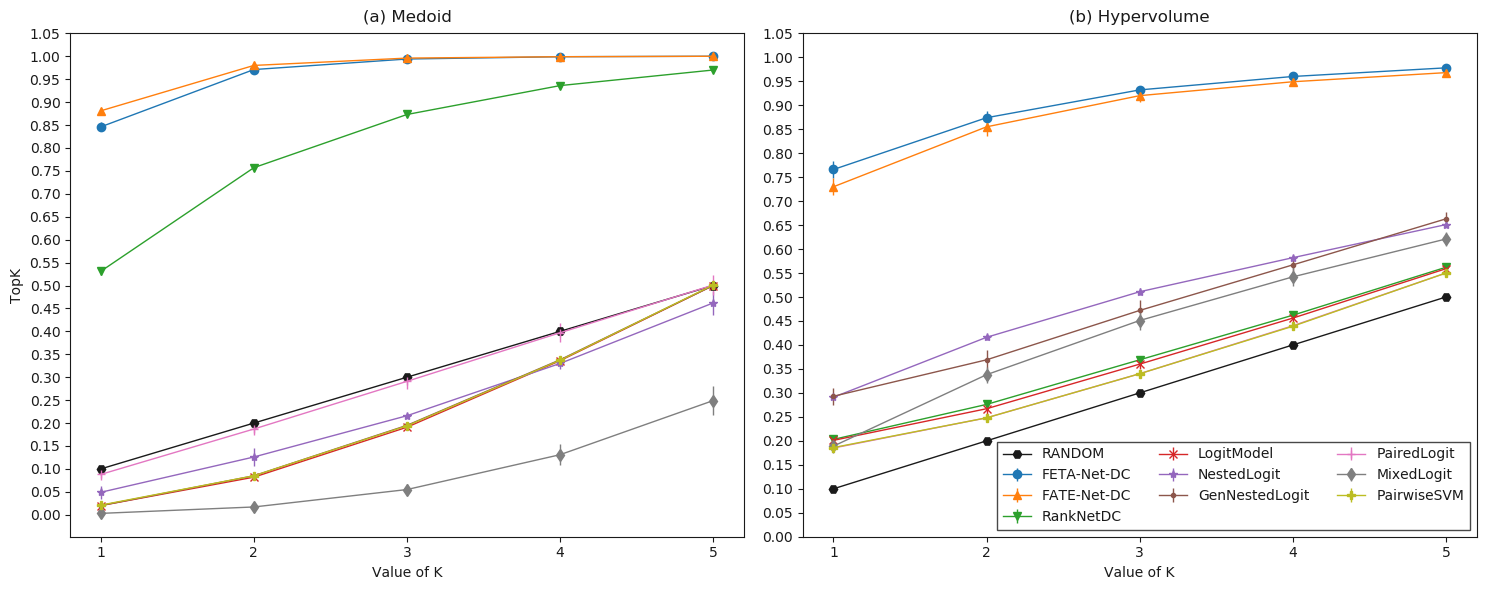

mnist_dc


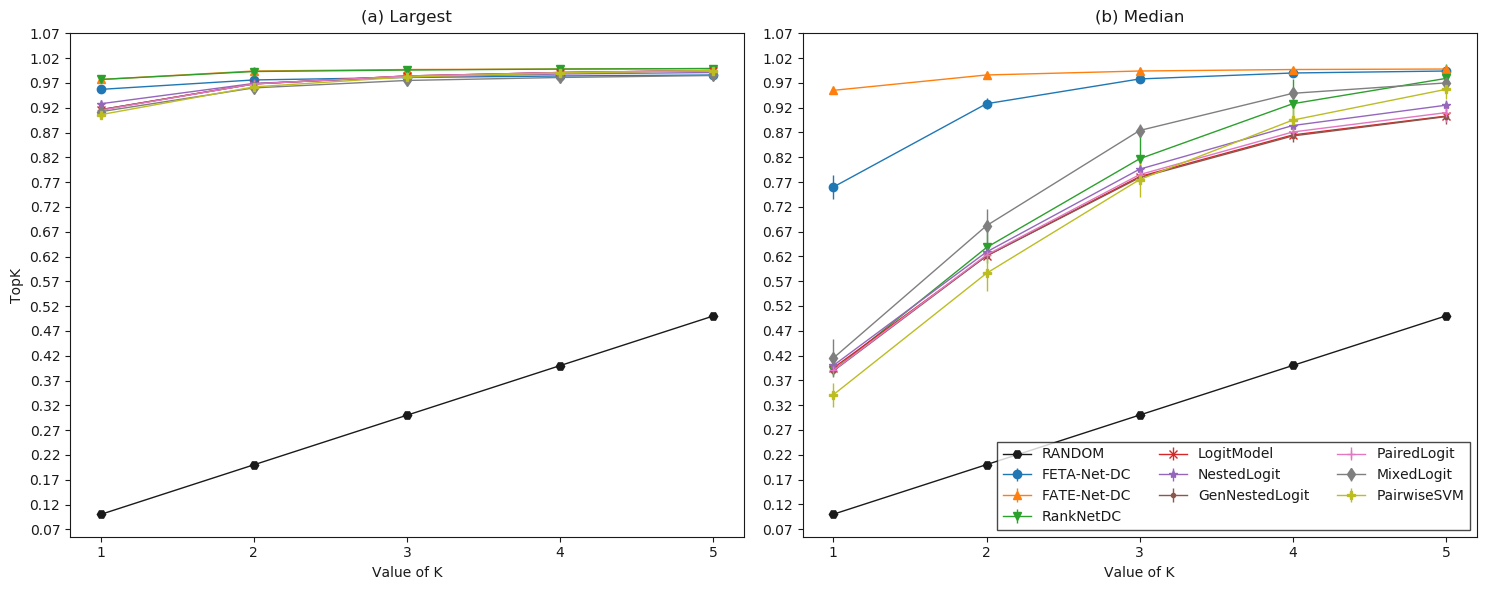

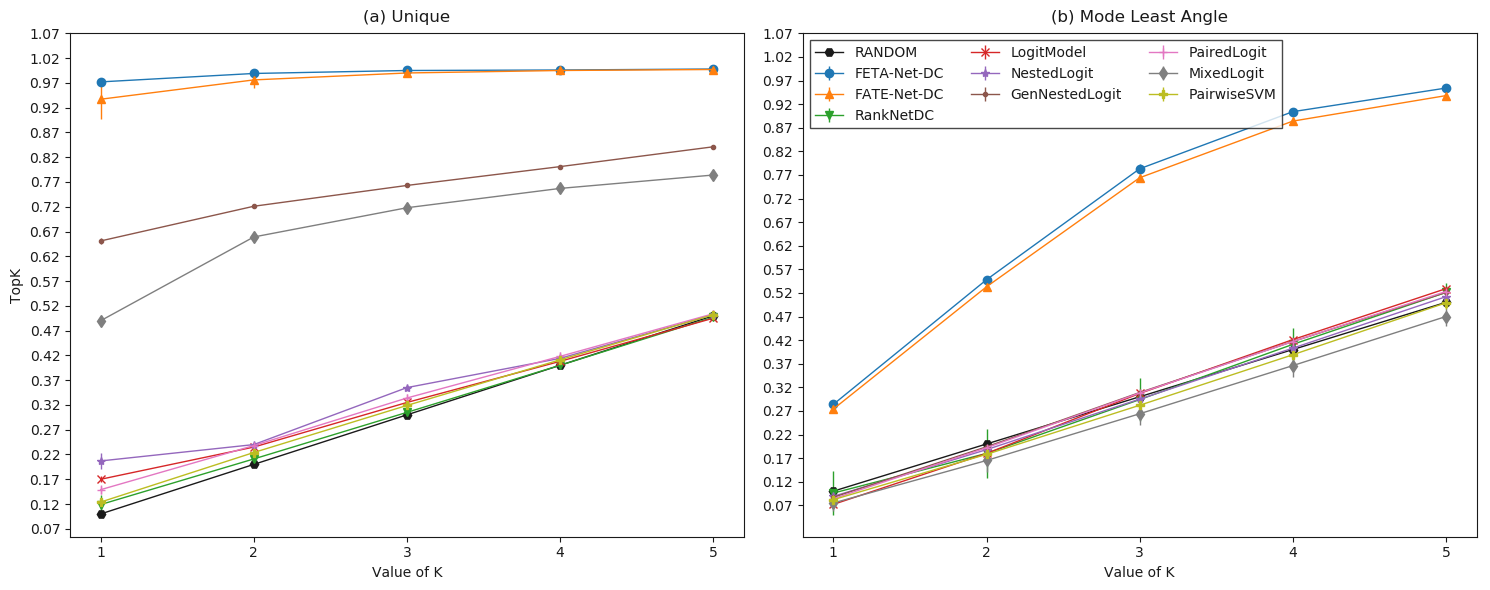

tag_genome_dc


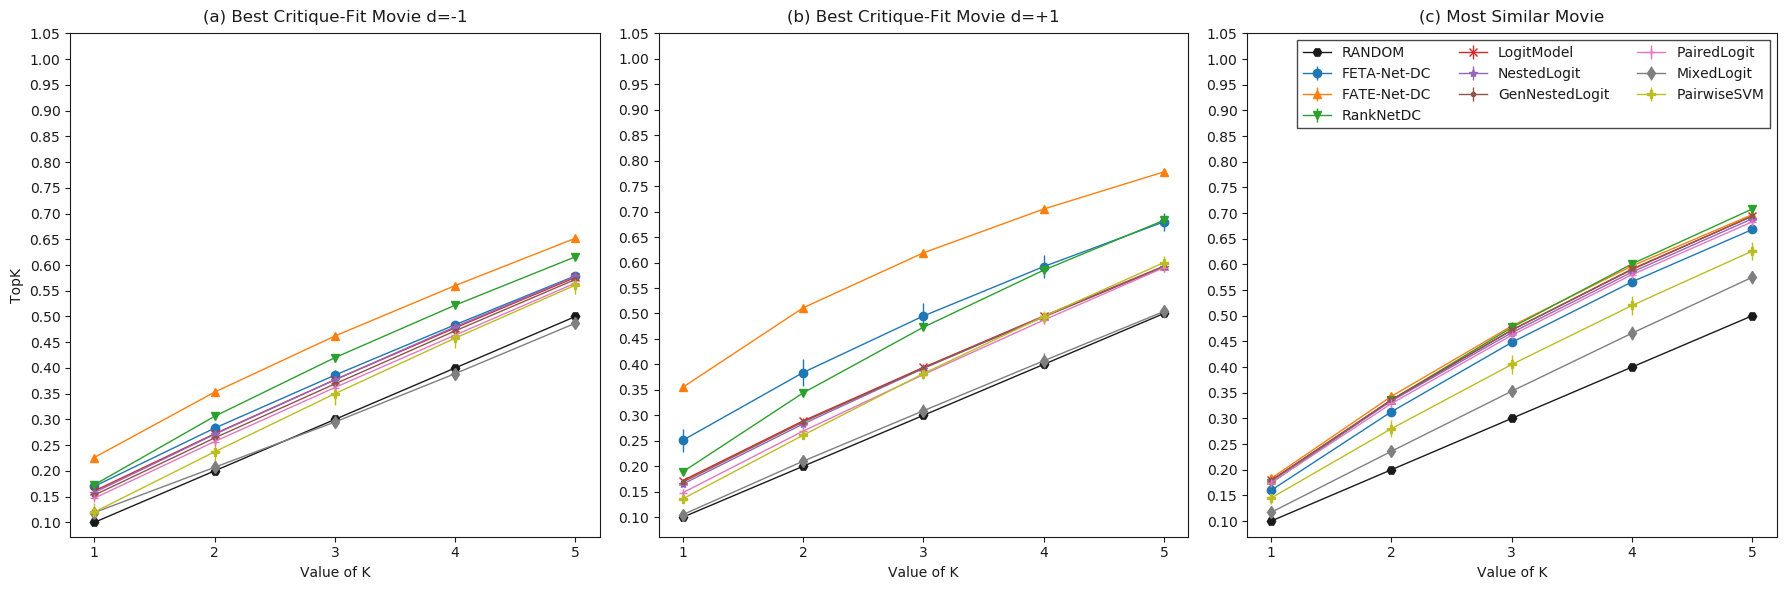

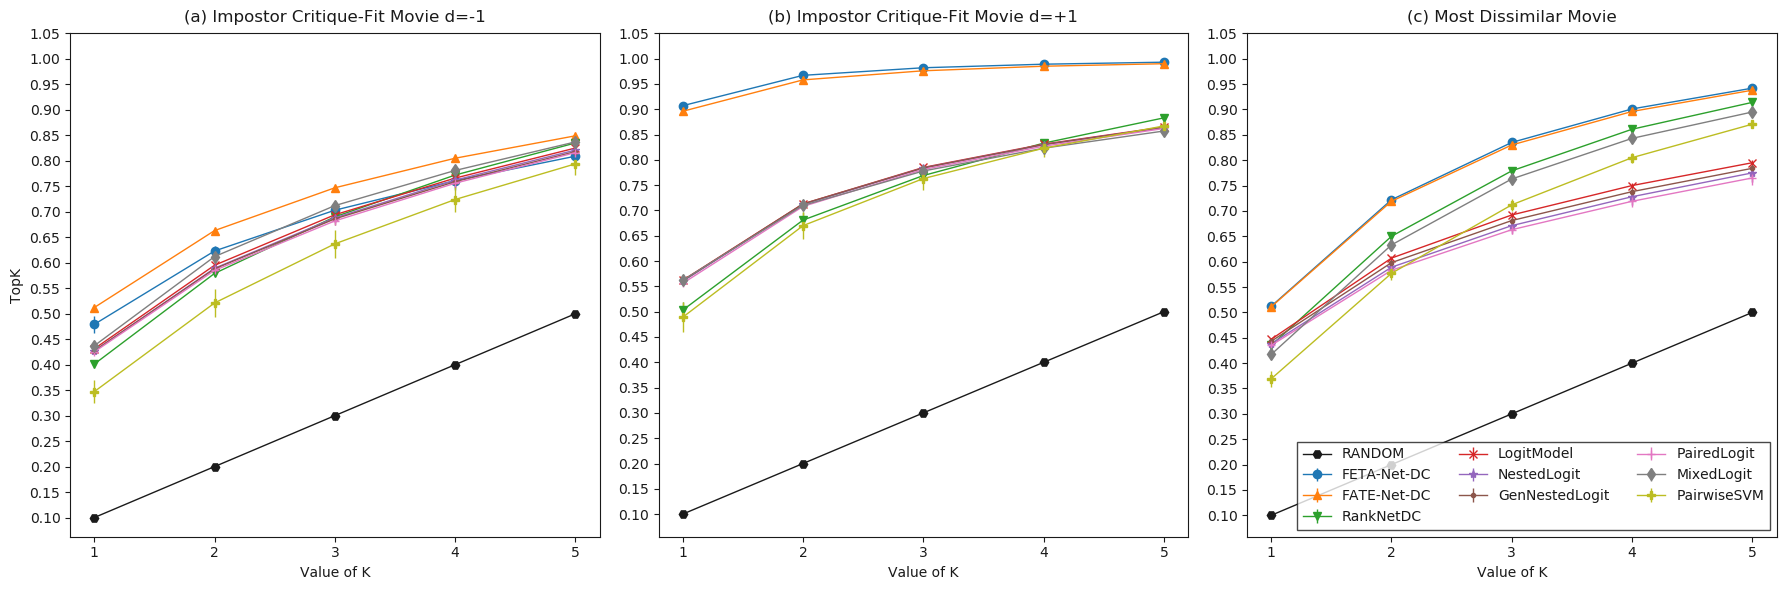

letor_dc


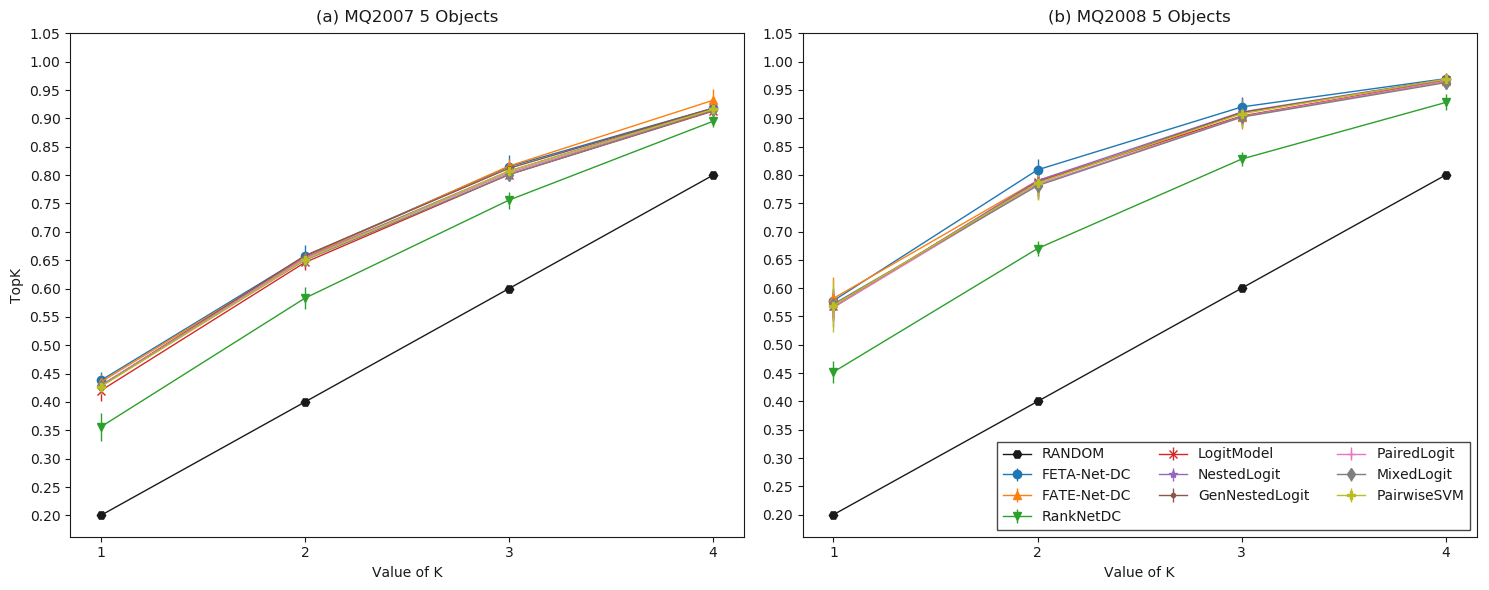

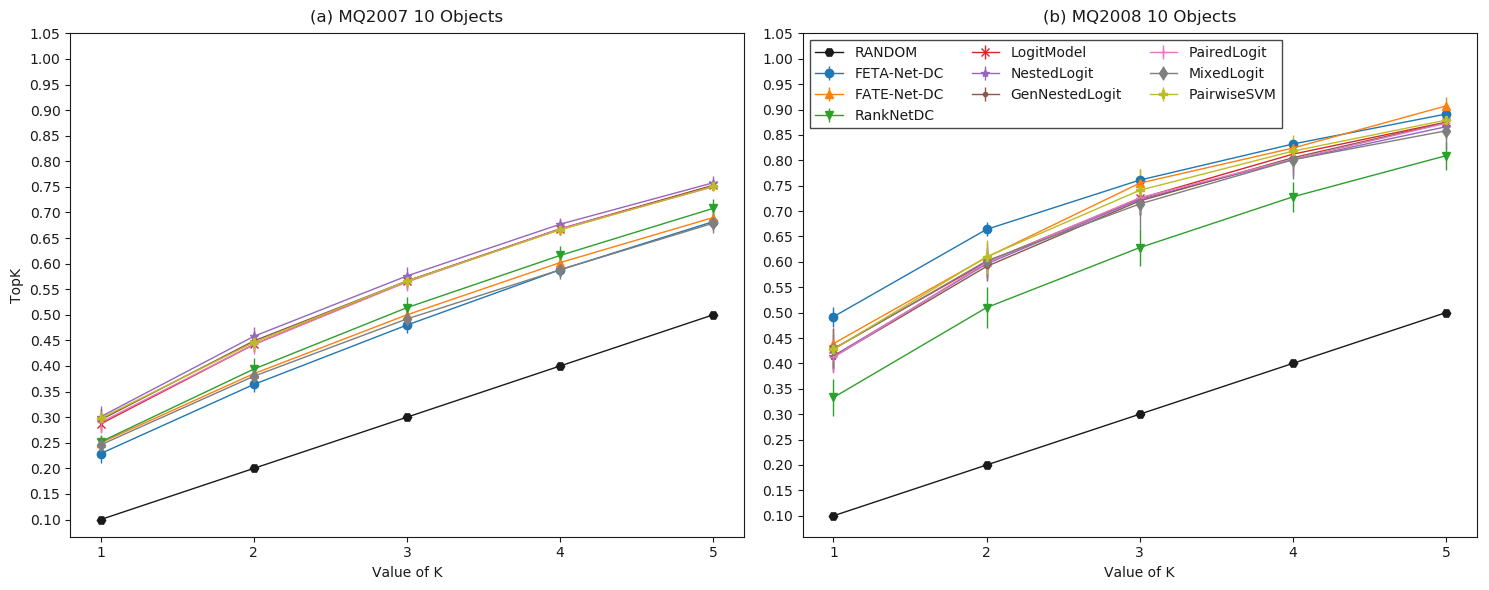

sushi_dc


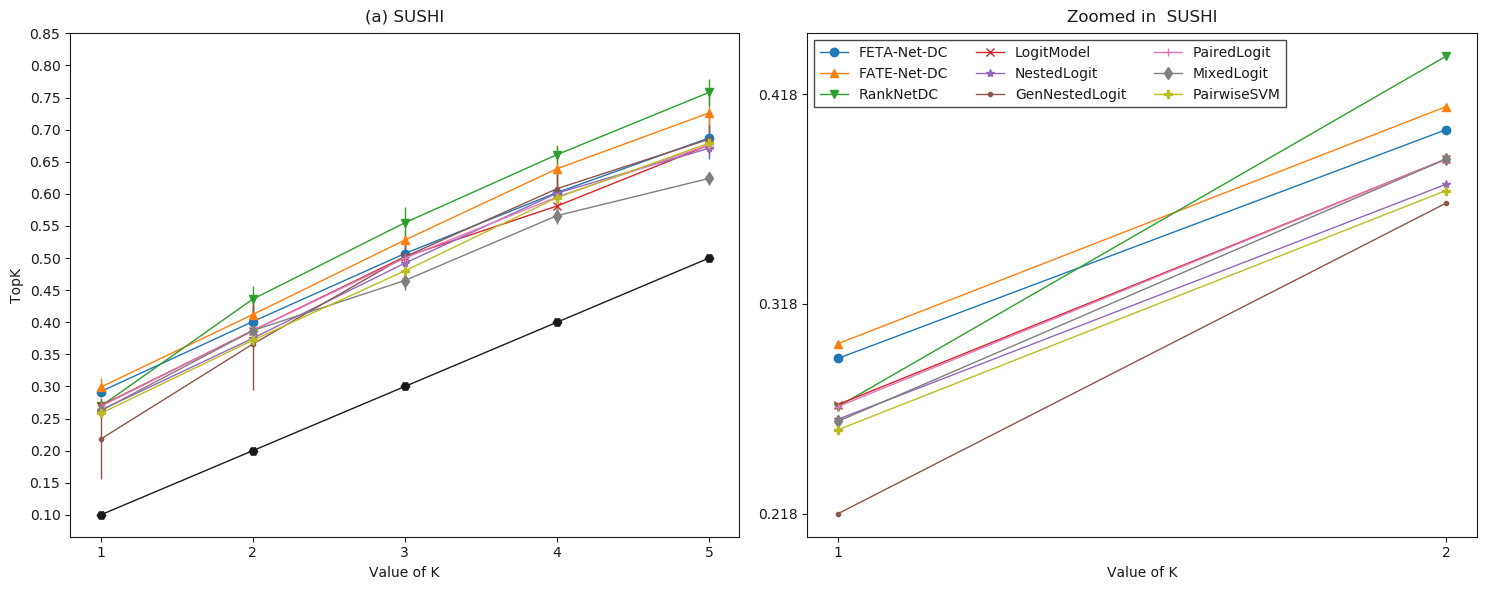

In [29]:
from constants import DCMS
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'LogitModel', 'NestedLogit', 'GenNestedLogit', 'PairedLogit', 'MixedLogit', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
models_dict = dict(zip(Dlower, models))
y_label="TopK"
x_label="Value of K"
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.05}
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [30]:
DATASET = datasets[0]
df_full, columns = get_results_for_dataset(DATASET, del_jid=False)
print(columns)
#df_full['zeroonerankaccuracy'] = 1 - df_full['zeroonerankloss']
df = df_full.loc[df_full.learner.str.contains("NESTED_LOGIT_MODEL")].sort_values(['learner', 'dataset'])
#df = df.loc[df.dataset.str.contains("Y_2008")].sort_values(['learner', 'dataset', 'job_id'])
df.head()

['job_id', 'dataset', 'learner', 'categoricalaccuracy', 'categoricaltopk2', 'categoricaltopk3', 'categoricaltopk4', 'categoricaltopk5', 'categoricaltopk6']


,job_id,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
107,1034,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2911,0.4131,0.5085,0.5798,0.6482,0.7191
106,1032,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2915,0.4207,0.5208,0.5917,0.6588,0.7270
105,1006,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2862,0.4090,0.5027,0.5737,0.6437,0.7170
84,1035,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2915,0.4161,0.5100,0.5814,0.6529,0.7258
83,1033,HYPERVOLUME,NESTED_LOGIT_MODEL,0.2955,0.4199,0.5129,0.5819,0.6501,0.7223


In [31]:
df = create_combined_dfs2(DATASET, latex_row=True)
df.sort_values(by='dataset')
df

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,Hypervolume,GenNestedLogit,0.293(18),0.369(20),0.472(21),0.567(18),0.663(14),0.756(9)
1,Hypervolume,MixedLogit,0.189(14),0.338(17),0.451(19),0.542(20),0.621(14),0.692(10)
2,Hypervolume,LogitModel,0.201(8),0.267(10),0.360(10),0.456(8),0.559(4),0.664(4)
3,Hypervolume,NestedLogit,0.291(3),0.416(5),0.511(7),0.582(6),0.651(6),0.722(4)
4,Hypervolume,PairedLogit,0.185(1),0.248(1),0.340(2),0.440(2),0.550(2),0.668(2)
5,Hypervolume,PairwiseSVM,0.186(1),0.248(1),0.340(2),0.439(2),0.550(2),0.667(2)
6,Hypervolume,FETA-Net-DC,0.766(18),0.874(15),0.932(5),0.960(2),0.978(1),0.990(2)
7,Hypervolume,RankNetDC,0.203(4),0.276(6),0.369(6),0.462(5),0.562(4),0.665(7)
8,Hypervolume,FATE-Net-DC,0.730(18),0.855(19),0.920(13),0.949(9),0.968(6),0.980(3)
9,Medoid,GenNestedLogit,0.020(1),0.085(2),0.195(4),0.338(3),0.500(1),0.661(5)


In [32]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    return [vals[0], vals[0] - vals[1]*1e-3]
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[['learner',col]].as_matrix()
        values = np.array([get_val(val[1])for val in values_str])
        maxi = np.where(values[:,0] == values[:,0][np.argmax(values[:,0])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df['learner'] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [34]:
import re
import string
grouped = df.groupby(['dataset'])
for name, group in grouped:
    
    custom_dict = {"PairwiseSVM":0, "RankNetDC":1, 'LogitModel':2, 'NestedLogit':3, 'GenNestedLogit':4, 
                   'PairedLogit':5, "GenNestedLogit":6, "MixedLogit":7, "FATE-Net-DC":8, "FETA-Net-DC":9}
    group['rank'] = group['learner'].map(custom_dict)
    group.sort_values(by='rank', inplace=True)
    del group["dataset"]
    del group['rank']
    group = mark_best(group)
    if len(group)==9:
        group['learner'] = ["pairwisesvm", "ranknetdc", "mnl", "nlm", "gnl", "pcl", "mlm", "fatedc", "fetadc"]
    print("name {}".format(name))
    group = group.drop(columns='categoricaltopk6')
    if "N_5" in name:
        group = group.drop(columns='categoricaltopk5')
    latex_code = group.to_latex(index = False)
    latex_code = latex_code.replace(' ',"")
    latex_code = latex_code.replace('&'," & ")
    latex_code = str(latex_code)
    for learner in group['learner']:
        latex_code = latex_code.replace(learner, "\\{}".format(learner))
    latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
    #latex_code = latex_code.replace("0.", ".")

    print(latex_code)
#df.T.to_latex()

name Hypervolume
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule
\pairwisesvm & 0.186(1) & 0.248(1) & 0.340(2) & 0.439(2) & 0.550(2)\\
\ranknetdc & 0.203(4) & 0.276(6) & 0.369(6) & 0.462(5) & 0.562(4)\\
\mnl & 0.201(8) & 0.267(10) & 0.360(10) & 0.456(8) & 0.559(4)\\
\nlm & 0.291(3) & 0.416(5) & 0.511(7) & 0.582(6) & 0.651(6)\\
\gnl & 0.185(1) & 0.248(1) & 0.340(2) & 0.440(2) & 0.550(2)\\
\pcl & 0.293(18) & 0.369(20) & 0.472(21) & 0.567(18) & 0.663(14)\\
\mlm & 0.189(14) & 0.338(17) & 0.451(19) & 0.542(20) & 0.621(14)\\
\fatedc & 0.730(18) & 0.855(19) & 0.920(13) & 0.949(9) & 0.968(6)\\
\fetadc & \bfseries 0.766(18) & \bfseries 0.874(15) & \bfseries 0.932(5) & \bfseries 0.960(2) & \bfseries 0.978(1)\\
\bottomrule
\end{tabular}

name Medoid
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule

In [33]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

In [ ]:
"UNIQUE_MAX_OCCURRING".lower()